In [ ]:
import numpy as np
import sys
import os
import pandas as pd
from SALib.analyze import morris as morris_analyze
import random


# Adjust the path to point to external/AlphaPEM
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.sampling.sampler import get_polarisation_curve_samples, build_fixed_parameters, sample_parameters, PARAMETER_RANGES
from src.analysis.sensitivity import generate_morris_samples, rescale_samples, apply_dependent_parameters, run_morris_analysis, plot_morris_grid, summarize_morris_results

In [ ]:


dependent_parameter_names=['Pc_des']
samples_df, trajectories, problem = generate_morris_samples(PARAMETER_RANGES, dependent_parameter_names)

df = rescale_samples(samples_df, PARAMETER_RANGES)

dependent_parameters = [{'parameter_name': 'Pc_des',
                         'function': lambda Pa_des: (np.maximum(1.1e5, Pa_des - 0.5e5), np.maximum(1.1e5, Pa_des - 0.1e5)),
                         'dependent_param': 'Pa_des'}]
df = apply_dependent_parameters(df, dependent_parameters)



In [ ]:
#df = get_polarisation_curve_samples(sampled_parameters=df.to_dict(orient='records'), fixed_parameters=build_fixed_parameters(), save_path="../data/raw/N10_levels4_seed42.pkl", save_every=10)


In [36]:
data = pd.read_pickle('../data/raw/N10_levels4_seed42.pkl')

In [ ]:


morris_all = run_morris_analysis(samples_df, problem, output=data['Ucell'])


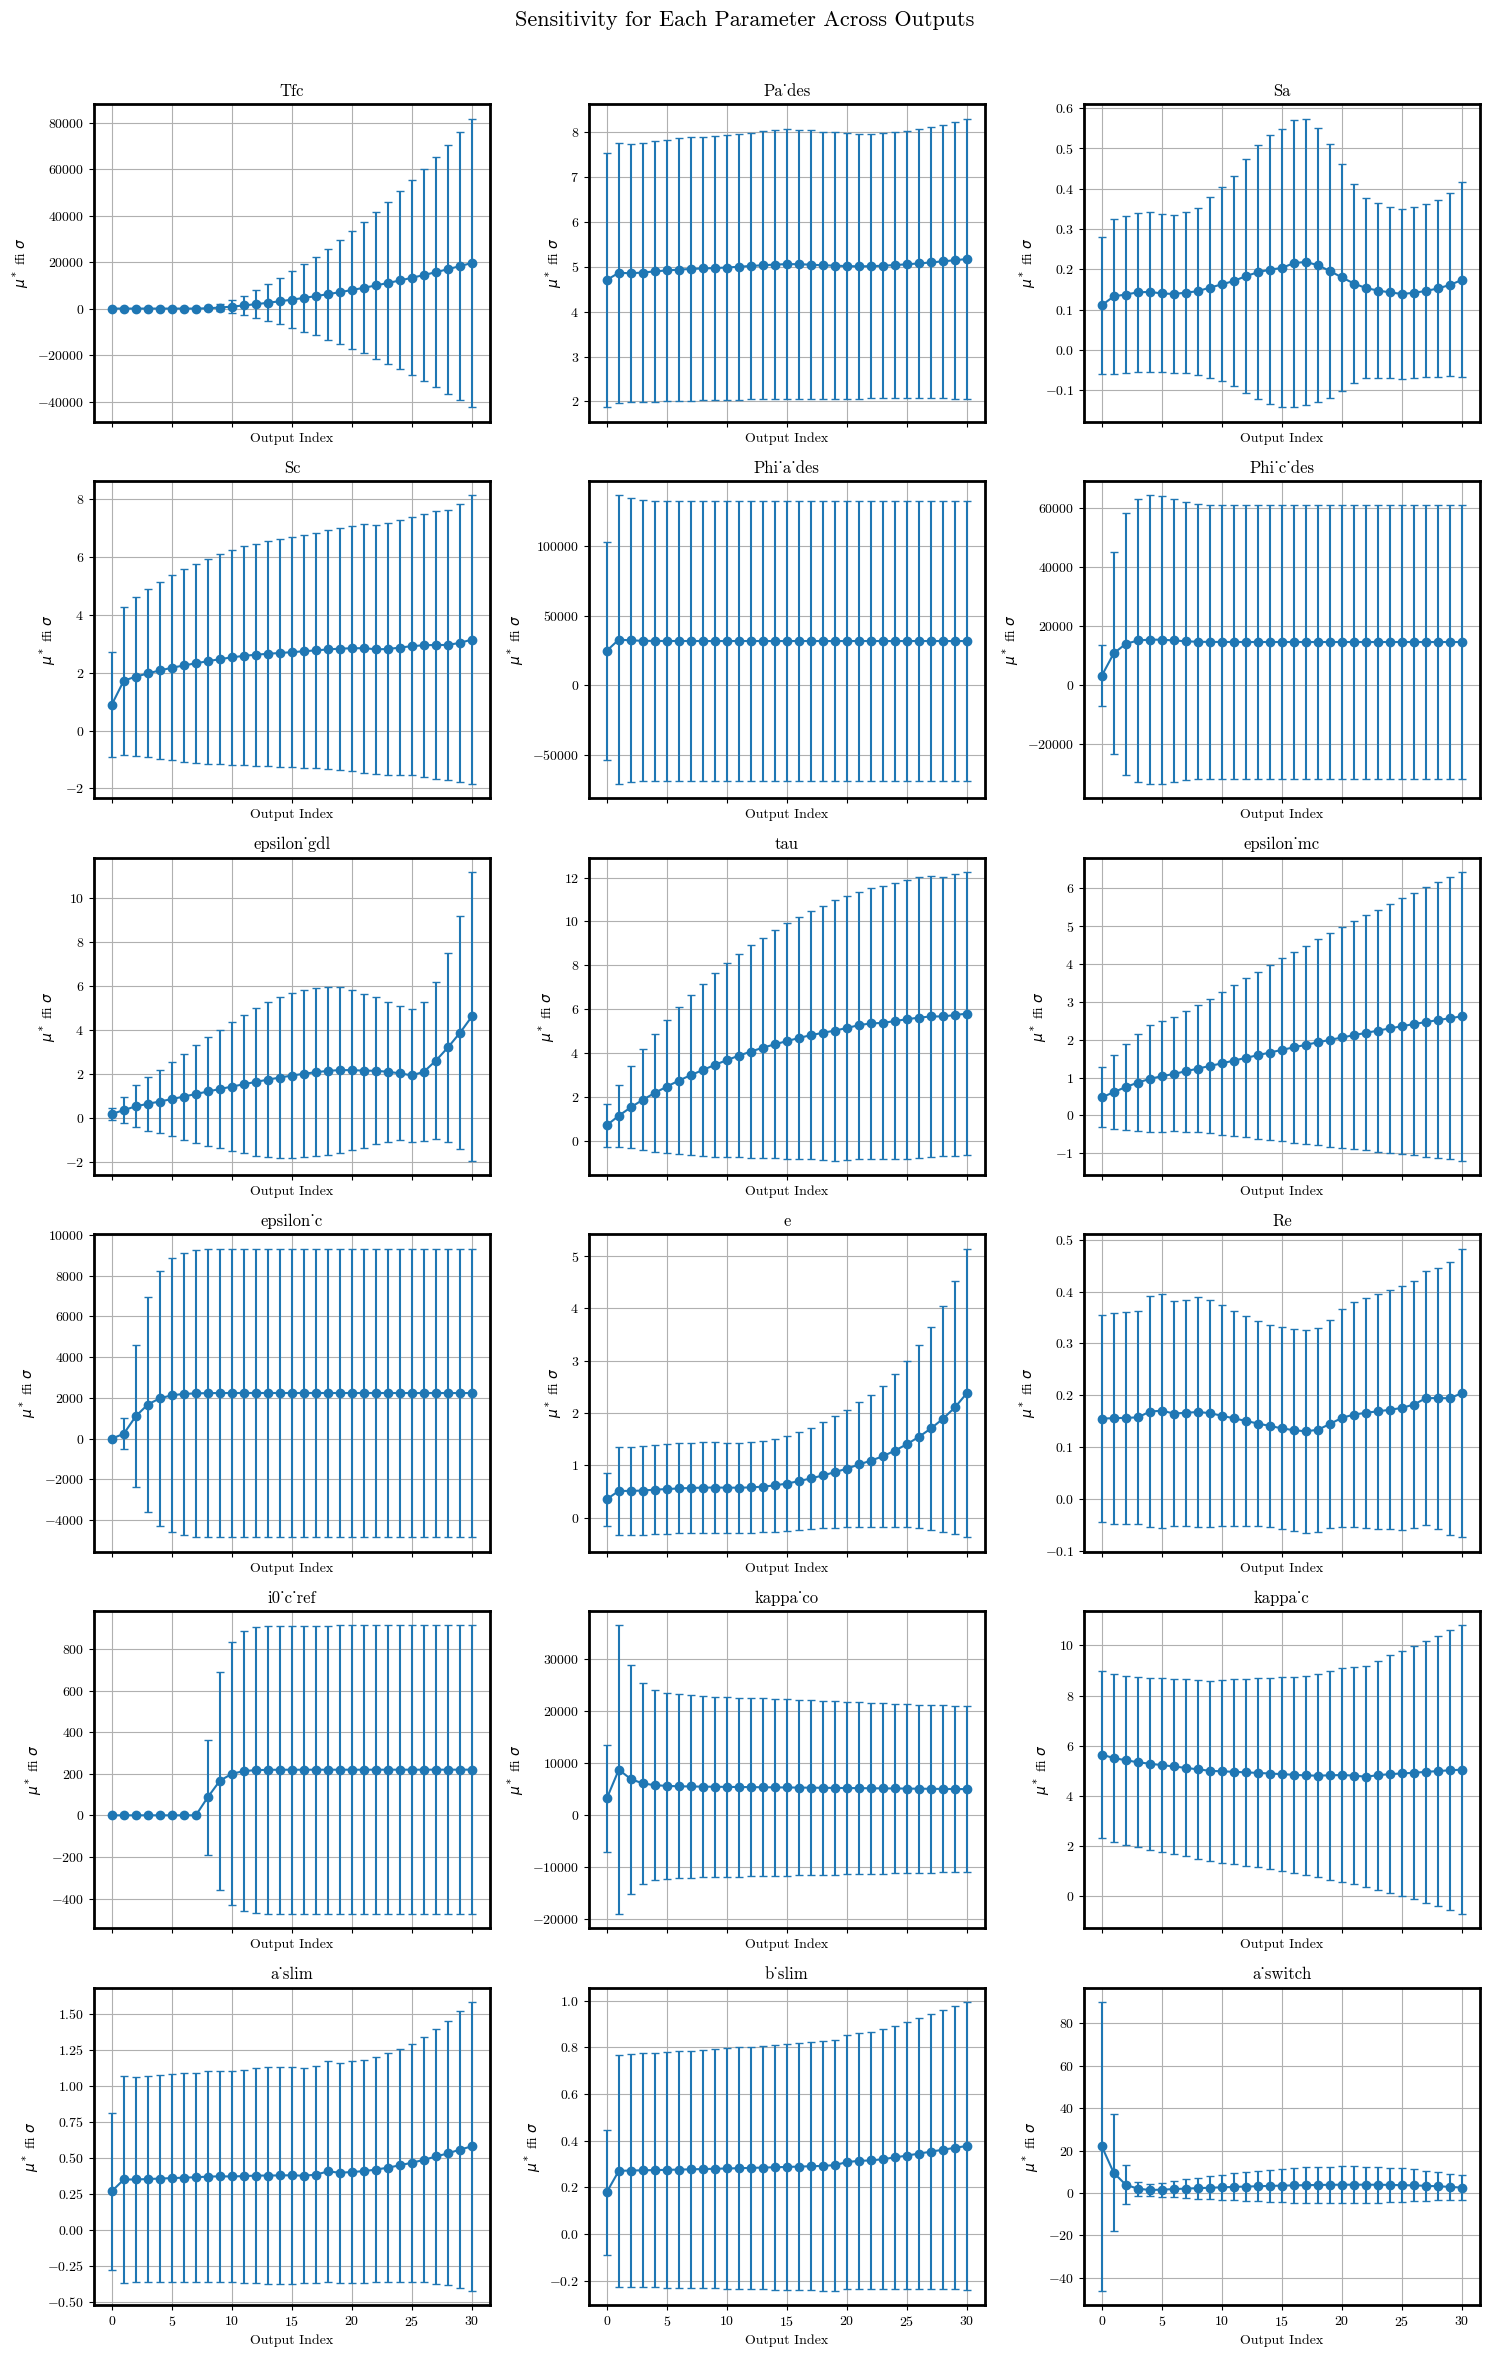

In [33]:
plot_morris_grid(morris_all, params=problem['names'], same_axis=False)

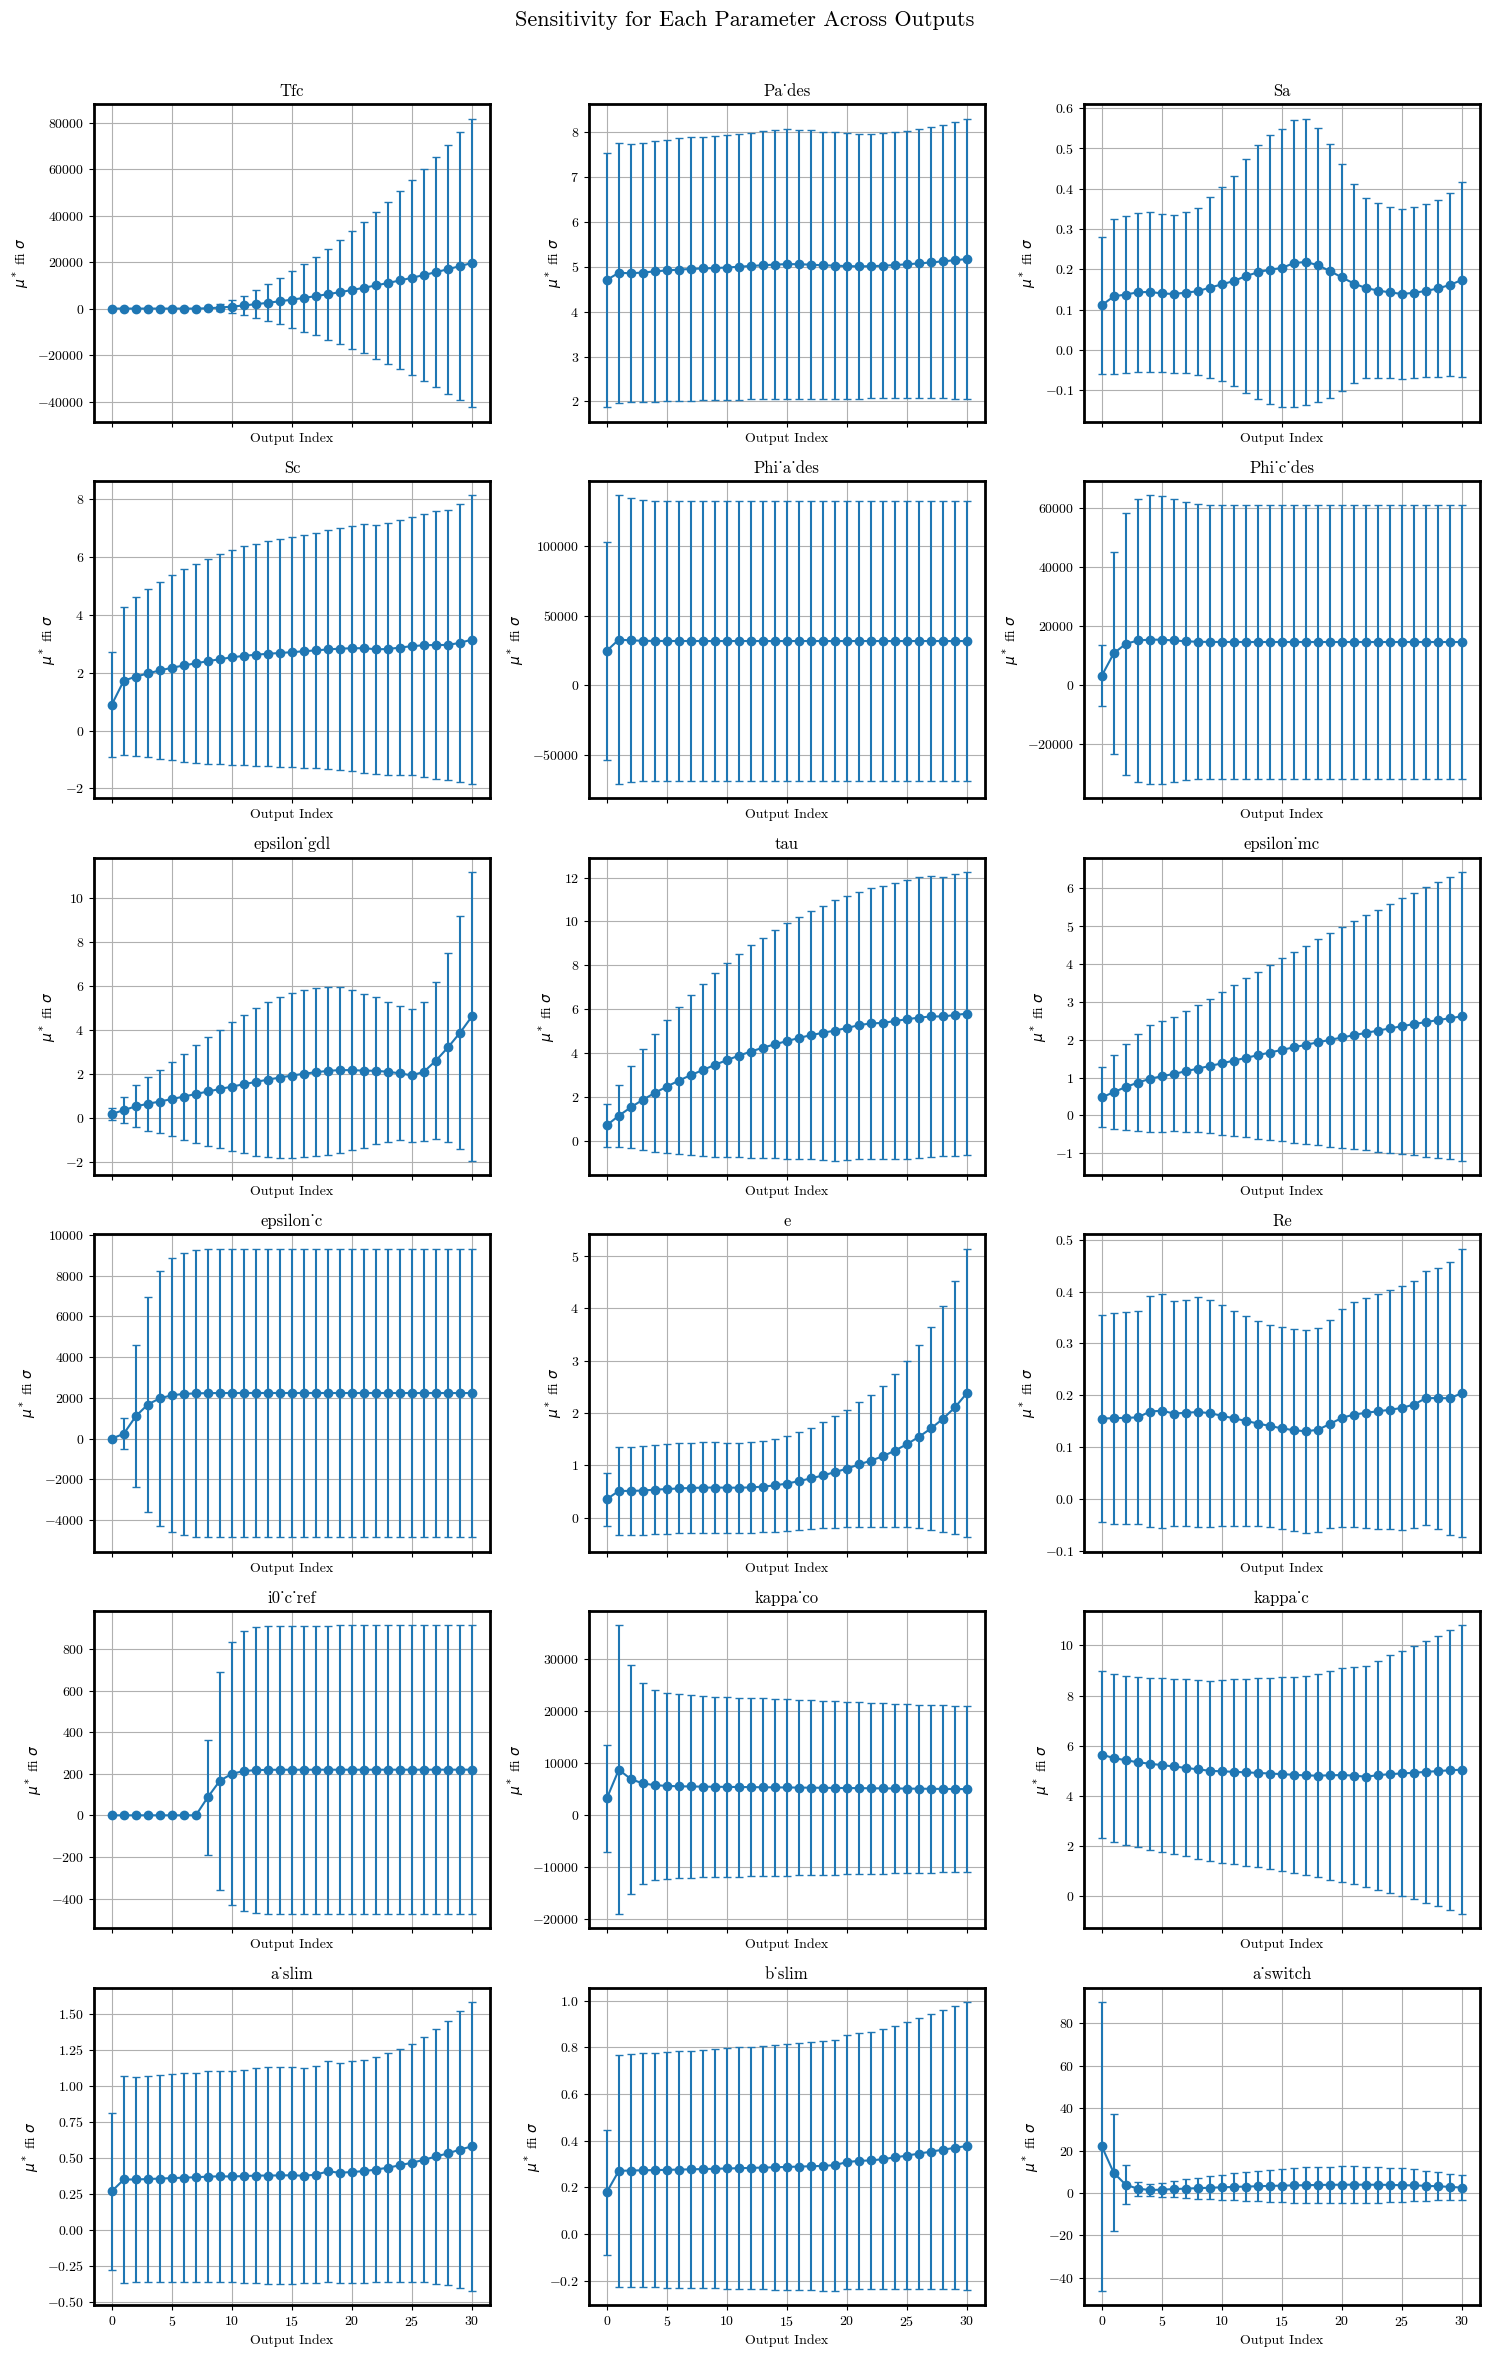

In [34]:
plot_morris_grid(morris_all, params=problem['names'], same_axis=False)


In [35]:
summarize_morris_results(morris_all, problem)

,Parameter,Mu*_mean,Mu*_std
0,Phi_a_des,31595.542477,1258.179368
1,Phi_c_des,14265.064501,2142.365122
2,Tfc,5979.956115,6249.471233
3,kappa_co,5453.908350,806.411341
4,epsilon_c,2032.426903,550.203692
5,i0_c_ref,156.351169,95.236062
6,kappa_c,5.018872,0.220099
7,Pa_des,4.995978,0.092853
8,tau,4.097631,1.478882
9,a_switch,3.912528,3.566454
